# Imports

In [1]:
import PyWGCNA
import pandas as pd
import numpy as np
import anndata as ad


In [2]:
def revert_from_conversion(adata):
    conversion_info = adata.uns.get('conversion_info', {})

    for key, original_type in conversion_info.items():
        df_name, col = key.split(':')
        df = getattr(adata, df_name)

        if 'datetime' in original_type.lower():
            df[col] = pd.to_datetime(df[col])
        elif 'timedelta' in original_type.lower():
            df[col] = pd.to_timedelta(df[col])
        elif original_type == 'category':
            df[col] = df[col].astype('category')
        elif 'int' in original_type.lower():
            df[col] = df[col].astype('Int64')  # Use nullable integer type
        elif 'float' in original_type.lower():
            df[col] = df[col].astype('float64')
        elif 'bool' in original_type.lower():
            df[col] = df[col].astype('boolean')
        # Other types will remain as they are

    return adata

# Read data

In [62]:
adata_nmf = ad.read_h5ad(r"/mnt/work/RO_src/Projects/THORA/DataProcessing/data/processed/adata_nmf_cp_82_samp.h5ad")
adata_nmf = revert_from_conversion(adata_nmf)

adata = ad.read_h5ad("/mnt/work/RO_src/Projects/THORA/DataProcessing/data/processed/bulk_adata_full.h5ad")
adata = revert_from_conversion(adata)

In [63]:
# Get columns that are in adata_nmf.obs but not in adata.obs
new_cols = [col for col in adata_nmf.obs.columns if col not in adata.obs.columns]

# Merge only the new columns from adata_nmf to adata
adata.obs = pd.concat([adata.obs, adata_nmf.obs[new_cols]], axis=1)

In [65]:
adata_cp = adata.copy()
adata_cp.obs = adata.obs[["ID_Sample","Organ","tnm_staging","radio_arm","status_ttp","status_os","sex","age_at_sample","brain_metastasis","SCLC_Subtype_de_novo","NMF_1_de_novo","NMF_2_de_novo","NMF_3_de_novo","NMF_4_de_novo","RSI","nmf_group_de_novo"]]

In [68]:
import PyWGCNA
geneExp_data = pd.DataFrame(data=adata.X, index=adata.obs.index, columns=adata.var.index)
# Create temp csv file of the geneExp_data and then load on the pyWGCNA
geneExp_data.to_csv('/home/rafaed/work/RO_src/STAnalysis/notebooks/downstream/Bulk RNA/WGCNA/expressionList.csv', index=True)

geneExp = '/home/rafaed/work/RO_src/STAnalysis/notebooks/downstream/Bulk RNA/WGCNA/expressionList.csv'
wgcna = PyWGCNA.WGCNA(name='SCLC', 
                              species='homo sapiens', 
                              geneExpPath=geneExp, 
                              outputPath='',
                              save=True,
                              networkType = 'signed',
                              TOMType = 'signed',
                              TPMcutoff = 1.5)

sampleInfo = pd.DataFrame(data=adata_cp.obs, index=adata_cp.obs.index)
sampleInfo.to_csv('/home/rafaed/work/RO_src/STAnalysis/notebooks/downstream/Bulk RNA/WGCNA/sampleInfo.csv', index=True)

geneList = pd.DataFrame(data=adata_cp.var["ENSG"], index=adata_cp.var.index)
geneList.to_csv('/home/rafaed/work/RO_src/STAnalysis/notebooks/downstream/Bulk RNA/WGCNA/geneList.csv', index=True)

Saving data to be True, checking requirements ...


In [69]:
wgcna.updateSampleInfo(path='/home/rafaed/work/RO_src/STAnalysis/notebooks/downstream/Bulk RNA/WGCNA/sampleInfo.csv', sep=',')
wgcna.updateGeneInfo(path='/home/rafaed/work/RO_src/STAnalysis/notebooks/downstream/Bulk RNA/WGCNA/geneList.csv', sep=',')

In [71]:
wgcna.geneExpr

AnnData object with n_obs × n_vars = 82 × 23154
    obs: 'ID_Sample', 'Organ', 'tnm_staging', 'radio_arm', 'status_ttp', 'status_os', 'sex', 'age_at_sample', 'brain_metastasis', 'SCLC_Subtype_de_novo', 'NMF_1_de_novo', 'NMF_2_de_novo', 'NMF_3_de_novo', 'NMF_4_de_novo', 'RSI', 'nmf_group_de_novo'
    var: 'ENSG'

Pre-processing...
	Detecting genes and samples with too many missing values...


	Done pre-processing..



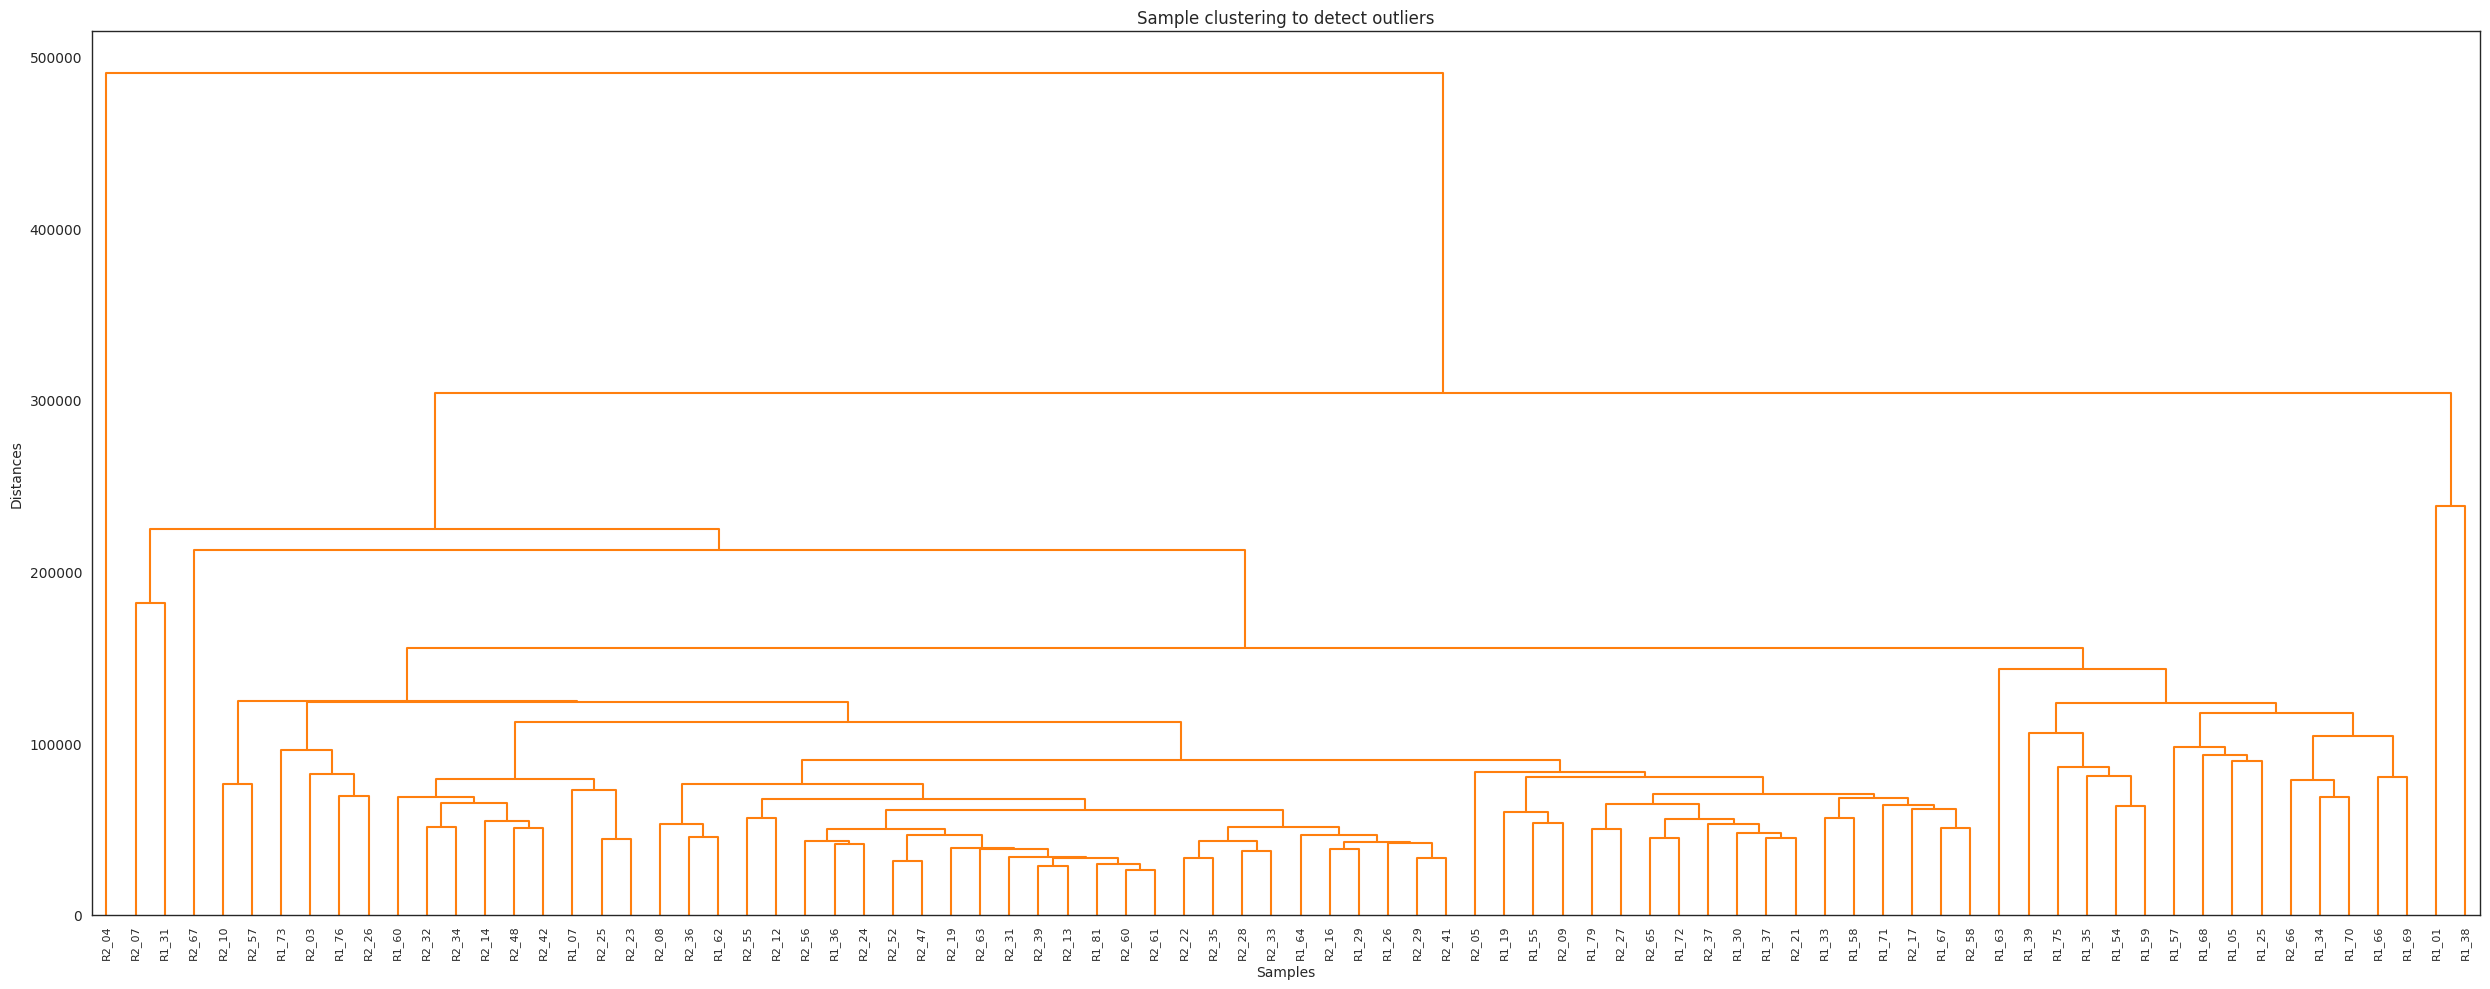

In [72]:
wgcna.preprocess()


In [ ]:
wgcna.findModules()

Run WGCNA...
pickSoftThreshold: calculating connectivity for given powers...
will use block size  1932


    Power  SFT.R.sq      slope truncated R.sq       mean(k)     median(k)  \
0       1   0.89491  11.449992       0.901052  16011.243728  16324.469239   
1       2  0.846722   4.862334       0.914553  11330.829965  11675.139846   
2       3  0.753104    2.62505       0.957806   8189.600272    8461.12087   
3       4  0.514366   1.483111       0.934662   6033.701659   6195.393826   
4       5  0.151344   0.516517       0.819463   4522.916966   4585.110341   
5       6   0.00292   -0.05754       0.732192   3443.632522   3425.979407   
6       7  0.158586  -0.424452       0.742124    2658.85484   2578.752619   
7       8  0.340962  -0.665624       0.788693   2078.922922   1955.728676   
8       9  0.465938  -0.850826       0.825549   1644.005365   1492.808728   
9      10  0.551135  -0.982551       0.856518   1313.436164   1146.190172   
10     11  0.619215  -1.078276       0.886783   1059.093457    886.946891   
11     13   0.70088  -1.220696       0.925807    705.690358    536.707817   

In [ ]:
# add color for metadata
wgcna.setMetadataColor('Sex', {'0': 'green',
                                       '1': 'yellow'})
wgcna.setMetadataColor('radio_arm', {'45y': 'darkviolet',
                                            '60gy': 'deeppink'})
wgcna.setMetadataColor('status_ttp', {'0': 'thistle',
                                            '1': 'plum'})

wgcna.setMetadataColor('status_os', {'0': 'violet',
                                            '1': 'purple'})
wgcna.setMetadataColor('Organ', {'Lung': 'red',
                                          'Lymph Node': 'blue'})